In [ ]:
"""
Author: Ze Hong Wu
Purpose: Part of the CSCI 49377 project's Stage 3 training process.
This notebook will see the following models trained and tested: VGGNet, ResNet, XCeption, DenseNet
"""

"\nAuthor: Ze Hong Wu\nPurpose: Part of the CSCI 49377 project's Stage 3 training process.\nThis notebook will see the following models trained and tested: VGGNet, ResNet, XCeption, DenseNet\n"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from glob import glob
import random


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, Dense, Dropout, Flatten, Reshape, GlobalAveragePooling2D, CenterCrop
from tensorflow.keras.backend import clear_session
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.saving import load_model
from tensorflow.keras.optimizers.legacy import Adam
# https://stackoverflow.com/questions/71153492/invalid-argument-error-graph-execution-error
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization, ReLU, Add, Activation, SeparableConv2D, Concatenate, AveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

## Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls /content/drive/MyDrive/49377_tfrecords

densenet  resnet34  test.tfrecord  train.tfrecord  val.tfrecord  vgg16	xception


In [ ]:
TFR_PATH = "/content/drive/MyDrive/49377_tfrecords/"
# Using an absolute path based on this one rumor I heard

In [ ]:
## DO NOT MOVE THIS CELL ANY LOWER; parse function needs labels
image_shape = (512, 512, 3)
labels = ['bell', 'dog', 'horse', 'house', 'tiger']

In [ ]:
def _parse_function(example):
    # Define your tfrecord again. The contents should be adjusted according to how you wrote your tfrecord file.
    keys_to_features = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Image as a raw byte string
        'label': tf.io.FixedLenFeature([], tf.int64),     # Label as an integer
    }

    # Parse the input `tf.train.Example` using the feature description dictionary above
    parsed_features = tf.io.parse_single_example(example, keys_to_features)

    # Decode the image data into an array
    image = tf.image.decode_png(parsed_features['image'], channels=3)
    image = tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32) / 255.0

    # We will use one-hot enocded labels
    label = parsed_features['label']
    label = tf.one_hot(label, depth=len(labels), dtype=tf.int64)

    return image, label

In [ ]:
def load_tfrecord_dataset(tfrecord_file, batch_size=32):
    # Load the dataset
    dataset = tf.data.TFRecordDataset(tfrecord_file, num_parallel_reads=tf.data.AUTOTUNE)


    # Parse the serialized data in the TFRecords
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(3 * batch_size)

    # Set the batch size
    dataset = dataset.batch(batch_size, drop_remainder=True)

    # Prefetch will enable the input pipeline to asynchronously fetch batches while the model is training
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [ ]:
#Paths to the TFRecord files

train_file = TFR_PATH + 'train.tfrecord'
val_file = TFR_PATH + 'val.tfrecord'
# I initially had the valid tfrecord named "valid.tfrecord"
# but model.fit() below insisted on looking for "val.tfrecord" during validation session
# (despite me manually passing it X_val for validation),
# which led to a Graph Execution Error and many open tabs trying to fix this bug.
# I don't know why this is the case and it's too late at night for me to be figuring that out.
test_file = TFR_PATH + 'test.tfrecord'

# Loading the datasets
X_train = load_tfrecord_dataset(train_file)
X_val = load_tfrecord_dataset(val_file)
X_test = load_tfrecord_dataset(test_file)

In [ ]:
type(X_test)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [ ]:
type(X_test.take(0)) # the first batch inthe dataset

tensorflow.python.data.ops.take_op._TakeDataset

In [ ]:
# https://stackoverflow.com/questions/67878735/how-to-change-the-dtype-of-data-in-tf-data-dataset
# The labels are in int64 format but the model outputs are in float32
# Macro F1Score doesn't work when that is the case
# I am casting the labels to float32
X_train = X_train.map(lambda x, y: (x, tf.cast(y, tf.float32)))
X_val = X_val.map(lambda x, y: (x, tf.cast(y, tf.float32)))
X_test = X_test.map(lambda x, y: (x, tf.cast(y, tf.float32)))


is loop running?
<class 'tensorflow.python.framework.ops.EagerTensor'>


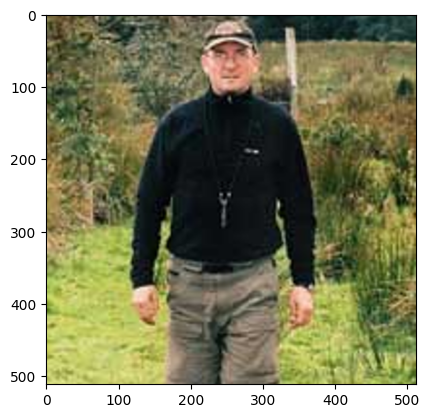

tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)


In [ ]:
dataset_batch = X_test.take(1)

# Take the first batch from the dataset
# Remember to usr take(1) and not take(0)
for batch, label in dataset_batch.take(1):
    # Extract the first image from the batch
    print("is loop running?")
    image = batch[0]  # This gets the first image in the batch
    print(type(image))

    # The image tensor shape is (512, 512, 3), you can now visualize it
    plt.imshow(image)
    plt.show()
    print(label[0])

In [ ]:
num_epochs = 16 # arbitrarily decided epoch count
batch_size = 32
train_samples_count = 18000
steps_per_epoch = train_samples_count // batch_size

## Summary

Model name | Loss | Accuracy | F1 | Training time | Epochs
--- | --- | --- | --- | --- | ---
VGG16 | 0.8977 | 0.6436 | 0.6479 | 2839s; 47m19s | 12
ResNet | 0.9376 | 0.7041 | 0.6992 | 2674s; 44m34s | 10
XCeption | 0.6541 | 0.7734 | 0.7782 | 3347s; 55m47s | 12
DenseNet | 0.6446 | 0.7686 | 0.7696 | 4327s; 72m7s | 16

Note that `Epochs` includes ones rolled back by early stopping.

## VGG16

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, Dense, Dropout, Flatten, Reshape, GlobalAveragePooling2D, CenterCrop
from tensorflow.keras.backend import clear_session
from tensorflow.keras.metrics import F1Score

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam
# https://stackoverflow.com/questions/71153492/invalid-argument-error-graph-execution-error
from tensorflow.keras.optimizers import SGD

In [ ]:
clear_session()

# This is the VGG16 architecture.
# Conv2D filter counts shrunk down by a factor of 2 except for the last three Conv2D layers.
my_vggnet = Sequential()

my_vggnet.add(Input(shape=image_shape))
my_vggnet.add(CenterCrop(224, 224)) # VGGnet cropped inputs to 224x224 as well; also, without this layer training sort of went poorly

my_vggnet.add(Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu"))
my_vggnet.add(Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu"))
my_vggnet.add(MaxPool2D(pool_size=(2,2), strides=2, padding="same"))

my_vggnet.add(Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"))
my_vggnet.add(Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"))
my_vggnet.add(MaxPool2D(pool_size=(2,2), strides=2, padding="same"))

my_vggnet.add(Conv2D(filters=128, kernel_size=3, strides=1, padding="same", activation="relu"))
my_vggnet.add(Conv2D(filters=128, kernel_size=3, strides=1, padding="same", activation="relu"))
my_vggnet.add(Conv2D(filters=128, kernel_size=1, strides=1, padding="same", activation="relu"))
my_vggnet.add(MaxPool2D(pool_size=(2,2), strides=2, padding="same"))

my_vggnet.add(Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu"))
my_vggnet.add(Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu"))
my_vggnet.add(Conv2D(filters=256, kernel_size=1, strides=1, padding="same", activation="relu"))
my_vggnet.add(MaxPool2D(pool_size=(2,2), strides=2, padding="same"))

my_vggnet.add(Conv2D(filters=512, kernel_size=3, strides=1, padding="same", activation="relu"))
my_vggnet.add(Conv2D(filters=512, kernel_size=3, strides=1, padding="same", activation="relu"))
my_vggnet.add(Conv2D(filters=512, kernel_size=1, strides=1, padding="same", activation="relu"))
my_vggnet.add(MaxPool2D(pool_size=(2,2), strides=2, padding="same"))

my_vggnet.add(Conv2D(filters=512, kernel_size=3, strides=1, padding="same", activation="relu"))
my_vggnet.add(MaxPool2D(pool_size=(3,3), strides=1, padding="valid")) # reduces dims of final filters, reduces first dense layer params count

my_vggnet.add(Flatten())
my_vggnet.add(Dense(512, activation="relu")) # Cut down from 4096 to reduce trainable params
my_vggnet.add(Dense(4096, activation="relu"))
my_vggnet.add(Dense(5, activation="softmax"))

my_vggnet.compile(optimizer=SGD(momentum=0.9),metrics=["accuracy", F1Score(average="macro")], loss="categorical_crossentropy")
# momentum of 0.9 is based on notes from the vggnet research paper

Quoted from the VGGNet paper:

`The ConvNet training procedure generally follows Krizhevsky et al. (2012) (except for sampling
the input crops from multi-scale training images, as explained later). Namely, the training is carried
out by optimising the multinomial logistic regression objective using mini-batch gradient descent
(based on back-propagation (LeCun et al., 1989)) with momentum. The batch size was set to 256,
momentum to 0.9. The training was regularised by weight decay (the L2 penalty multiplier set to
5 · 10^−4) and dropout regularisation for the first two fully-connected layers (dropout ratio set to 0.5).
The learning rate was initially set to 10^−2, and then decreased by a factor of 10 when the validation
set accuracy stopped improving. In total, the learning rate was decreased 3 times, and the learning
was stopped after 370K iterations (74 epochs)`

In [ ]:
my_vggnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop (CenterCrop)    (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                        

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(
    TFR_PATH+"vgg16/vgg16_best_model_val_loss.keras",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=3,
                           min_delta=0, restore_best_weights=True)

In [ ]:
history = my_vggnet.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, early_stop])

Epoch 1/16
    562/Unknown - 210s 365ms/step - loss: 1.6098 - accuracy: 0.2037 - f1_score: 0.1999
Epoch 1: val_loss improved from inf to 1.60697, saving model to /content/drive/MyDrive/49377_tfrecords/vgg16_best_model_val_loss.keras
562/562 [==============================] - 239s 416ms/step - loss: 1.6098 - accuracy: 0.2037 - f1_score: 0.1999 - val_loss: 1.6070 - val_accuracy: 0.2295 - val_f1_score: 0.1281
Epoch 2/16
562/562 [==============================] - ETA: 0s - loss: 1.5897 - accuracy: 0.2435 - f1_score: 0.2205
Epoch 2: val_loss improved from 1.60697 to 1.54235, saving model to /content/drive/MyDrive/49377_tfrecords/vgg16_best_model_val_loss.keras
562/562 [==============================] - 247s 438ms/step - loss: 1.5897 - accuracy: 0.2435 - f1_score: 0.2205 - val_loss: 1.5423 - val_accuracy: 0.3076 - val_f1_score: 0.2936
Epoch 3/16
562/562 [==============================] - ETA: 0s - loss: 1.5241 - accuracy: 0.3224 - f1_score: 0.3003
Epoch 3: val_loss improved from 1.54235 to 1

In [ ]:
# example evaluating with tf.data.Dataset
scores = my_vggnet.evaluate(X_test, steps=32)

32/32 [==============================] - 12s 361ms/step - loss: 0.8925 - accuracy: 0.6445 - f1_score: 0.6479


In [ ]:
from tensorflow.keras.saving import load_model
saved_model = load_model(TFR_PATH+"vgg16/vgg16_best_model_val_loss.keras")
scores2 = saved_model.evaluate(X_test, steps=32)

32/32 [==============================] - 14s 383ms/step - loss: 0.8977 - accuracy: 0.6436 - f1_score: 0.6479


The best model found during training had a val_loss of 0.844, a val_accuracy of 0.6692, and a val_f1 of 0.6687. When evaluated on the testing images, it produced an accuracy of 0.6436 and an f1_score of 0.6479.

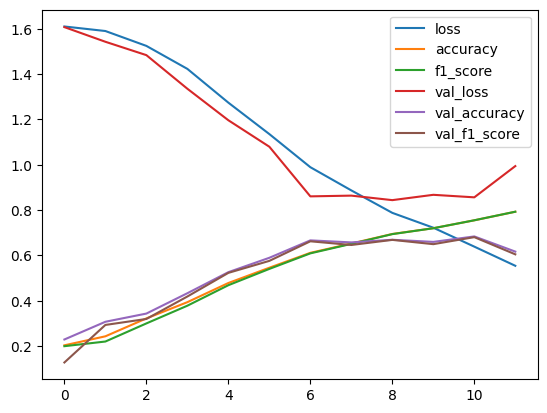

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.savefig(TFR_PATH+"vgg16/vgg16_losses_over_time.png")
plt.show()

The val_loss more or less plateaus out by epoch 6 and potentially begins overfitting by epoch 10. There are many possible reasons for this, some of which may be related to my potentially out of place efforts to pare down the model's parameter counts. This will be investigated further during the next stage.

In [ ]:
my_vggnet.save(TFR_PATH+"vgg16/vgg16_16epochs.keras")

In [ ]:
! ls /content/drive/MyDrive/49377_tfrecords/

resnet34  test.tfrecord  train.tfrecord  val.tfrecord  vgg16


# ResNet34

In [ ]:
from tensorflow.keras.layers import BatchNormalization, ReLU, Add, Activation
from tensorflow.keras import Model

In [ ]:
def add_skip_connection_block(x_shape, filters: int, upscale: bool, name: str):
  """
  FUNCTION DEPRECATED; IT DOES NOT WORK WITH THE TENSORFLOW FUNCTIONAL SYSTEM.

  This function returns the output of a skip connection block, given filters count and a choice to upscale or not.
  A number of these skip blocks form the ResNet architecture.

  Reference:
  https://stackoverflow.com/questions/58530328/cannot-obtain-the-output-of-intermediate-sub-model-layers-with-tf2-0-keras
  """
  x = Input(shape=x_shape)
  x_func = Conv2D(filters=filters, kernel_size=3, strides=1, padding="same")(x)
  x_func = BatchNormalization()(x_func)
  x_func = ReLU()(x_func)
  x_func = Conv2D(filters=filters, kernel_size=3, strides=1, padding="same")(x_func)
  x_func = BatchNormalization()(x_func)
  if upscale:
    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding="same")(x)
  x_connected = Add()([x, x_func])
  output = ReLU(x_connected)
  return Model(x, output, name=name)

In [ ]:
clear_session()
# This is the ResNet-34 architecture.
input = Input(shape=image_shape)
# Crop and initial convolution
#x = CenterCrop(224, 224)(input) # Commented out this layer to see what changes
x = Conv2D(filters=64, kernel_size=7, strides=2, padding="same", activation="relu")(input)
x = MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)

# Add many skip connections
filters = 64
for i in range(16):
  if i in [3,7,13]:
    filters *= 2
    x_func = Conv2D(filters=filters, kernel_size=3, strides=2, padding="same")(x)
  else:
    x_func = Conv2D(filters=filters, kernel_size=3, strides=1, padding="same")(x)
  x_func = BatchNormalization()(x_func)
  x_func = ReLU()(x_func)
  x_func = Conv2D(filters=filters, kernel_size=3, strides=1, padding="same")(x_func)
  x_func = BatchNormalization()(x_func)
  if i in [3,7,13]:
    x = Conv2D(filters=filters, kernel_size=1, strides=2)(x)
  x_connected = Add()([x, x_func])
  x = ReLU()(x_connected)

# What the code would look like if the add function works:
# x = add_skip_connection_block(x.shape[-1], filters=64, upscale=False, name="skip1")(x)
# x = add_skip_connection_block(x.shape, filters=64, upscale=False, name="skip2")(x)
# x = add_skip_connection_block(x.shape, filters=64, upscale=False, name="skip3")(x)

# x = add_skip_connection_block(x.shape, filters=128, upscale=True, name="skip4")(x)
# x = add_skip_connection_block(x.shape, filters=128, upscale=False, name="skip5")(x)
# x = add_skip_connection_block(x.shape, filters=128, upscale=False, name="skip6")(x)
# x = add_skip_connection_block(x.shape, filters=128, upscale=False, name="skip7")(x)

# x = add_skip_connection_block(x.shape, filters=256, upscale=True, name="skip8")(x)
# x = add_skip_connection_block(x.shape, filters=256, upscale=False, name="skip9")(x)
# x = add_skip_connection_block(x.shape, filters=256, upscale=False, name="skip10")(x)
# x = add_skip_connection_block(x.shape, filters=256, upscale=False, name="skip11")(x)
# x = add_skip_connection_block(x.shape, filters=256, upscale=False, name="skip12")(x)
# x = add_skip_connection_block(x.shape, filters=256, upscale=False, name="skip13")(x)

# x = add_skip_connection_block(x.shape, filters=512, upscale=True, name="skip14")(x)
# x = add_skip_connection_block(x.shape, filters=512, upscale=False, name="skip15")(x)
# x = add_skip_connection_block(x.shape, filters=512, upscale=False, name="skip16")(x)

# pooling and output dense layer
x = GlobalAveragePooling2D()(x)
output = Dense(5, activation="softmax")(x)

my_resnet34 = Model(inputs=input, outputs=output)

my_resnet34.compile(optimizer=SGD(momentum=0.9, weight_decay=0.0001), metrics=["accuracy", F1Score(average="macro")],
                    loss="categorical_crossentropy")


Quoted from the ResNet paper:

`Based on the above plain network, we
insert shortcut connections (Fig. 3, right) which turn the
network into its counterpart residual version. The identity
shortcuts (Eqn.(1)) can be directly used when the input and
output are of the same dimensions (solid line shortcuts in
Fig. 3). When the dimensions increase (dotted line shortcuts
in Fig. 3), we consider two options: (A) The shortcut still
performs identity mapping, with extra zero entries padded
for increasing dimensions. This option introduces no extra
parameter; (B) The projection shortcut in Eqn.(2) is used to
match dimensions (done by 1×1 convolutions). For both
options, when the shortcuts go across feature maps of two
sizes, they are performed with a stride of 2.`

The upscaling conv2d layers are implemented to satisfy option B.

`Our implementation for ImageNet follows the practice
in [21, 41]. The image is resized with its shorter side randomly
sampled in [256, 480] for scale augmentation [41].
A 224×224 crop is randomly sampled from an image or its
horizontal flip, with the per-pixel mean subtracted [21]. The
standard color augmentation in [21] is used. We adopt batch
normalization (BN) [16] right after each convolution and
before activation, following [16]. We initialize the weights
as in [13] and train all plain/residual nets from scratch. We
use SGD with a mini-batch size of 256. The learning rate
starts from 0.1 and is divided by 10 when the error plateaus,
and the models are trained for up to 60 × 104 iterations. We
use a weight decay of 0.0001 and a momentum of 0.9. We
do not use dropout [14], following the practice in [16].`

The batch-norms between the layers and ReLUs is and the choise of applying momentum and weight decay to SGD was motivated by this description.

In [ ]:
my_resnet34._name = "ResNet-34"
my_resnet34.summary()

Model: "ResNet-34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['max_pooling2d[0][0]'

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(
    TFR_PATH+"resnet34/resnet34_nocrop_best_model_val_loss.keras",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)

In [ ]:
history = my_resnet34.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, early_stop])

Epoch 1/16
    562/Unknown - 243s 403ms/step - loss: 1.4088 - accuracy: 0.4400 - f1_score: 0.4352
Epoch 1: val_loss improved from inf to 1.67606, saving model to /content/drive/MyDrive/49377_tfrecords/resnet34/resnet34_nocrop_best_model_val_loss.keras
562/562 [==============================] - 271s 451ms/step - loss: 1.4088 - accuracy: 0.4400 - f1_score: 0.4352 - val_loss: 1.6761 - val_accuracy: 0.4384 - val_f1_score: 0.3930
Epoch 2/16
562/562 [==============================] - ETA: 0s - loss: 0.9492 - accuracy: 0.6393 - f1_score: 0.6377
Epoch 2: val_loss improved from 1.67606 to 0.95610, saving model to /content/drive/MyDrive/49377_tfrecords/resnet34/resnet34_nocrop_best_model_val_loss.keras
562/562 [==============================] - 278s 492ms/step - loss: 0.9492 - accuracy: 0.6393 - f1_score: 0.6377 - val_loss: 0.9561 - val_accuracy: 0.6228 - val_f1_score: 0.6347
Epoch 3/16
562/562 [==============================] - ETA: 0s - loss: 0.7340 - accuracy: 0.7225 - f1_score: 0.7221
Epoch 

The original ResNet34 model returned a loss of 1.017, an accuracy of 0.6357, and an F1 of 0.6364. The modified ResNet34 model without image cropping at the start has a loss of 0.9376, an accuracy of 0.7041, and an F1 of 0.6992.

Possible explanatons for this include image cropping removing important features vital to properly identifying the image.

In [ ]:
# example evaluating with tf.data.Dataset
scores = my_resnet34.evaluate(X_test, steps=32)

32/32 [==============================] - 13s 381ms/step - loss: 1.0170 - accuracy: 0.6357 - f1_score: 0.6364


In [ ]:
# for the no-cropping version
# looks a lot better
scores = my_resnet34.evaluate(X_test, steps=32)

32/32 [==============================] - 12s 317ms/step - loss: 0.9376 - accuracy: 0.7041 - f1_score: 0.6992


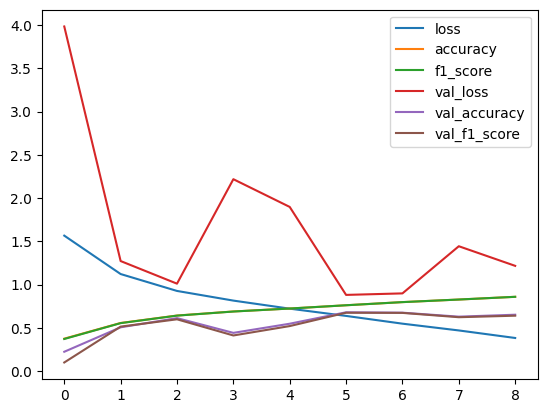

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# # Draw the losses over time using plt
# losses = pd.DataFrame(history.history).plot();
# plt.savefig(TFR_PATH+"resnet34/resnet34_nocrop_losses_over_time.png")
# plt.show()

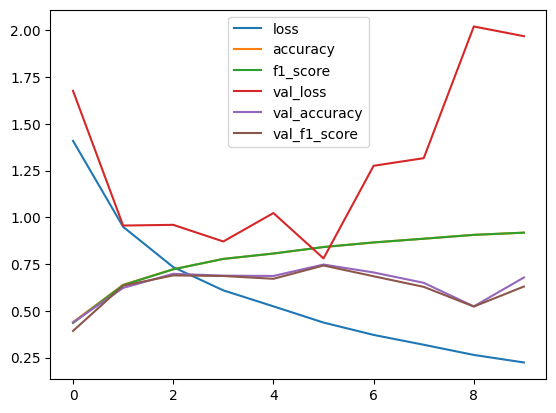

In [ ]:
# Draw the losses over time using plt
# For the no-cropping version
# Note that model checkpoints saved it at epoch 5 where val_loss was lowest
losses = pd.DataFrame(history.history).plot();
plt.savefig(TFR_PATH+"resnet34/resnet34_nocrop_losses_over_time.png")
plt.show()

In [ ]:
my_resnet34.save(TFR_PATH+"resnet34/resnet34_16epochs.keras")

In [ ]:
! ls /content/drive/MyDrive/49377_tfrecords/resnet34

resnet34_best_model_val_loss.keras  resnet34_nocrop_best_model_val_loss.keras
resnet34_losses_over_time.png	    resnet34_nocrop_losses_over_time.png


## XCeption

In [ ]:
clear_session()
# This is the XCeption architecture.
input = Input(shape=image_shape)

# Note that all Convolution and SeparableConvolution layers are followed by batch normalization [7] (not included in the diagram).
# Quoted from the XCeption paper
x = Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu")(input)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)

# filters = 64 # this value will be overwritten soon
# For the first three separable skip connection blocks
for filters in [128, 256, 728]:
  x_func = ReLU()(x)
  x_func = SeparableConv2D(filters=filters, kernel_size=3, strides=1, padding="same")(x_func)
  x_func = BatchNormalization()(x_func)
  x_func = ReLU()(x_func)
  x_func = SeparableConv2D(filters=filters, kernel_size=3, strides=1, padding="same")(x_func)
  x_func = BatchNormalization()(x_func)
  x_func = MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x_func)

  x = Conv2D(filters=filters, kernel_size=1, strides=2)(x)
  x = BatchNormalization()(x)
  x = Add()([x, x_func])
  #x = ReLU()(x_connected)

# next 8 728x728 blocks
for i in range(8):
  filters=728
  x_func = ReLU()(x)
  x_func = SeparableConv2D(filters=filters, kernel_size=3, strides=1, padding="same")(x)
  x_func = BatchNormalization()(x_func)
  x_func = ReLU()(x_func)
  x_func = SeparableConv2D(filters=filters, kernel_size=3, strides=1, padding="same")(x_func)
  x_func = BatchNormalization()(x_func)
  x_func = ReLU()(x_func)
  x_func = SeparableConv2D(filters=filters, kernel_size=3, strides=1, padding="same")(x_func)
  x_func = BatchNormalization()(x_func)

  x = Add()([x, x_func])
  #x = ReLU()(x_connected)

# last block for exit flow
x_func = ReLU()(x)
x_func = SeparableConv2D(filters=728, kernel_size=3, strides=1, padding="same")(x)
x_func = BatchNormalization()(x_func)
x_func = ReLU()(x_func)
x_func = SeparableConv2D(filters=1024, kernel_size=3, strides=1, padding="same")(x_func)
x_func = BatchNormalization()(x_func)
x_func = MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x_func)

x = Conv2D(filters=1024, kernel_size=1, strides=2)(x)
x = BatchNormalization()(x)
x = Add()([x, x_func])
#x = ReLU()(x_connected)

# last layers in exit flow
x = SeparableConv2D(filters=1536, kernel_size=3, strides=1, activation="relu")(x)
x = SeparableConv2D(filters=2048, kernel_size=3, strides=1, activation="relu")(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x) # the authors included a Dropout of 0.5 for ImageNet to prevent overfitting
# Optional fully connected layers not included
output = Dense(5, activation="softmax")(x)

my_xception = Model(inputs=input, outputs=output)

my_xception.compile(optimizer=SGD(momentum=0.9, weight_decay=0.00001, learning_rate=0.045), # learning rate as chosen by authors for ImageNet
                    metrics=["accuracy", F1Score(average="macro")], loss="categorical_crossentropy")

In [ ]:
my_xception._name = "XCeption"
my_xception.summary()

Model: "XCeption"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         18496     ['batch_normalization[0

In [ ]:
! ls /content/drive/MyDrive/49377_tfrecords/

resnet34  test.tfrecord  train.tfrecord  val.tfrecord  vgg16  xception


In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(
    TFR_PATH+"xception/xception_nocrop_best_model_val_loss.keras",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors used LR decay of 0.94 every 2 epochs
  if epoch == 1: return 0.045
  if epoch%2 == 0: return lr * 0.94
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
history = my_xception.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, early_stop, lr_scheduler])

Epoch 1/16
    562/Unknown - 271s 449ms/step - loss: 1.3292 - accuracy: 0.4178 - f1_score: 0.3995
Epoch 1: val_loss improved from inf to 1.84707, saving model to /content/drive/MyDrive/49377_tfrecords/xception/xception_nocrop_best_model_val_loss.keras
562/562 [==============================] - 311s 520ms/step - loss: 1.3292 - accuracy: 0.4178 - f1_score: 0.3995 - val_loss: 1.8471 - val_accuracy: 0.4268 - val_f1_score: 0.3597 - lr: 0.0423
Epoch 2/16
562/562 [==============================] - ETA: 0s - loss: 0.9213 - accuracy: 0.6466 - f1_score: 0.6467
Epoch 2: val_loss improved from 1.84707 to 1.23729, saving model to /content/drive/MyDrive/49377_tfrecords/xception/xception_nocrop_best_model_val_loss.keras
562/562 [==============================] - 281s 498ms/step - loss: 0.9213 - accuracy: 0.6466 - f1_score: 0.6467 - val_loss: 1.2373 - val_accuracy: 0.5888 - val_f1_score: 0.5681 - lr: 0.0450
Epoch 3/16
562/562 [==============================] - ETA: 0s - loss: 0.7247 - accuracy: 0.7305

In [ ]:
# example evaluating with tf.data.Dataset
scores = my_xception.evaluate(X_test, steps=32)

32/32 [==============================] - 23s 523ms/step - loss: 0.6541 - accuracy: 0.7734 - f1_score: 0.7782


The XCeption model achieved a loss of 0.6541, an accuracy of 0.7734, and an F1 of 0.7782.

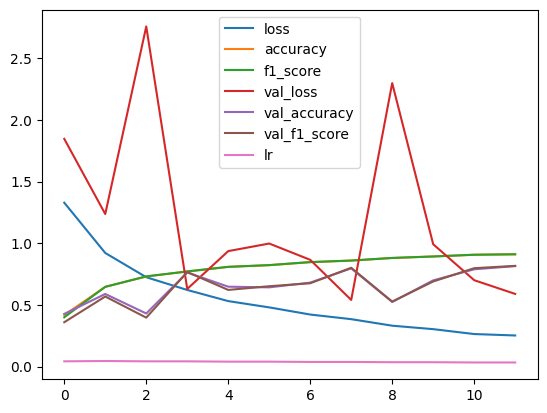

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
# val_loss looks chaotic; perhaps it needs a lot more training?
losses = pd.DataFrame(history.history).plot();
plt.savefig(TFR_PATH+"xception/xception_nocrop_losses_over_time.png")
plt.show()

## DenseNet

In [ ]:
clear_session()
# This is a shrunk down version of the DenseNet-121 architecture.
# The number of Conv blocks have been halved across the board.
# Without this change, the Colab instance would consume all RAM and crash when training.
filters=32
compression_factor=0.5
input = Input(shape=image_shape)
x = Conv2D(filters=64, kernel_size=7, strides=2, padding="same", activation="relu")(input)
x = MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)

# Conv blocks

for repetition in [3,6,12,8]:
  for i in range(repetition):
    y = BatchNormalization()(x)
    y = ReLU()(y)
    y = Conv2D(filters=filters*4, kernel_size=1, strides=1, padding = 'same')(y)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    y = Conv2D(filters=filters, kernel_size=3, strides=1, padding = 'same')(y)
    x = Concatenate()([y,x])
  if repetition != 16: # last conv block doesn't get a transition layer
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=int(x.shape[-1]*compression_factor), kernel_size=1, strides=1, padding = 'same')(x)
    x = AveragePooling2D(pool_size=(2,2), strides=2, padding="same")(x)

x = GlobalAveragePooling2D()(x)
output = Dense(5, activation="softmax")(x)

my_densenet = Model(inputs=input, outputs=output)
my_densenet.compile(optimizer=SGD(momentum=0.9, weight_decay=0.00001, learning_rate=0.1), # learning rate as chosen by authors for ImageNet
                    metrics=["accuracy", F1Score(average="macro")], loss="categorical_crossentropy")

In [ ]:
my_densenet._name = "DenseNet"
my_densenet.summary()

Model: "DenseNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['max_pooling2d[0][0]']

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(
    TFR_PATH+"densenet/densenet_nocrop_best_model_val_loss.keras",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  if epoch == 1: return 0.01
  if epoch == 8 or epoch == 12: return lr * 0.1
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
history = my_densenet.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, early_stop, lr_scheduler])

Epoch 1/16
    562/Unknown - 297s 462ms/step - loss: 1.6074 - accuracy: 0.3126 - f1_score: 0.3023
Epoch 1: val_loss improved from inf to 1.46512, saving model to /content/drive/MyDrive/49377_tfrecords/densenet/densenet_nocrop_best_model_val_loss.keras
562/562 [==============================] - 341s 541ms/step - loss: 1.6074 - accuracy: 0.3126 - f1_score: 0.3023 - val_loss: 1.4651 - val_accuracy: 0.3808 - val_f1_score: 0.3255 - lr: 0.1000
Epoch 2/16
562/562 [==============================] - ETA: 0s - loss: 1.3190 - accuracy: 0.4507 - f1_score: 0.4361
Epoch 2: val_loss improved from 1.46512 to 1.26984, saving model to /content/drive/MyDrive/49377_tfrecords/densenet/densenet_nocrop_best_model_val_loss.keras
562/562 [==============================] - 264s 468ms/step - loss: 1.3190 - accuracy: 0.4507 - f1_score: 0.4361 - val_loss: 1.2698 - val_accuracy: 0.4763 - val_f1_score: 0.4603 - lr: 0.0100
Epoch 3/16
562/562 [==============================] - ETA: 0s - loss: 1.2187 - accuracy: 0.5065

In [ ]:
# example evaluating with tf.data.Dataset
scores = my_densenet.evaluate(X_test, steps=32)

32/32 [==============================] - 16s 402ms/step - loss: 0.6446 - accuracy: 0.7686 - f1_score: 0.7696


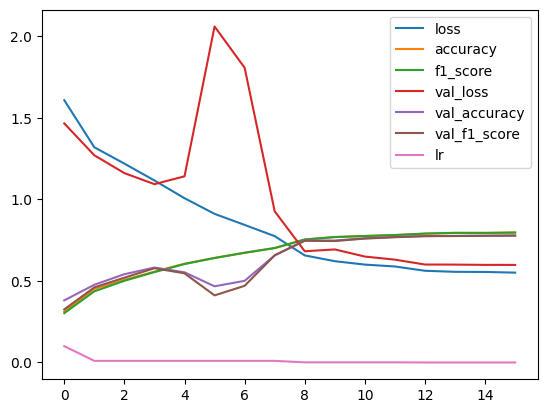

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
# A very significant case of double descent, it seems
losses = pd.DataFrame(history.history).plot();
plt.savefig(TFR_PATH+"densenet/densenet_nocrop_losses_over_time.png")
plt.show()

In [ ]:
! ls /content/drive/MyDrive/49377_tfrecords/densenet

densenet_best_model_architecture.png	   densenet_nocrop_losses_over_time.png
densenet_nocrop_best_model_val_loss.keras


In [ ]:
! pip install visualkeras
# nifty little package for visualizing a .keras model without having to fiddle with LaTeX files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 9.2 MB/s eta 0:00:00


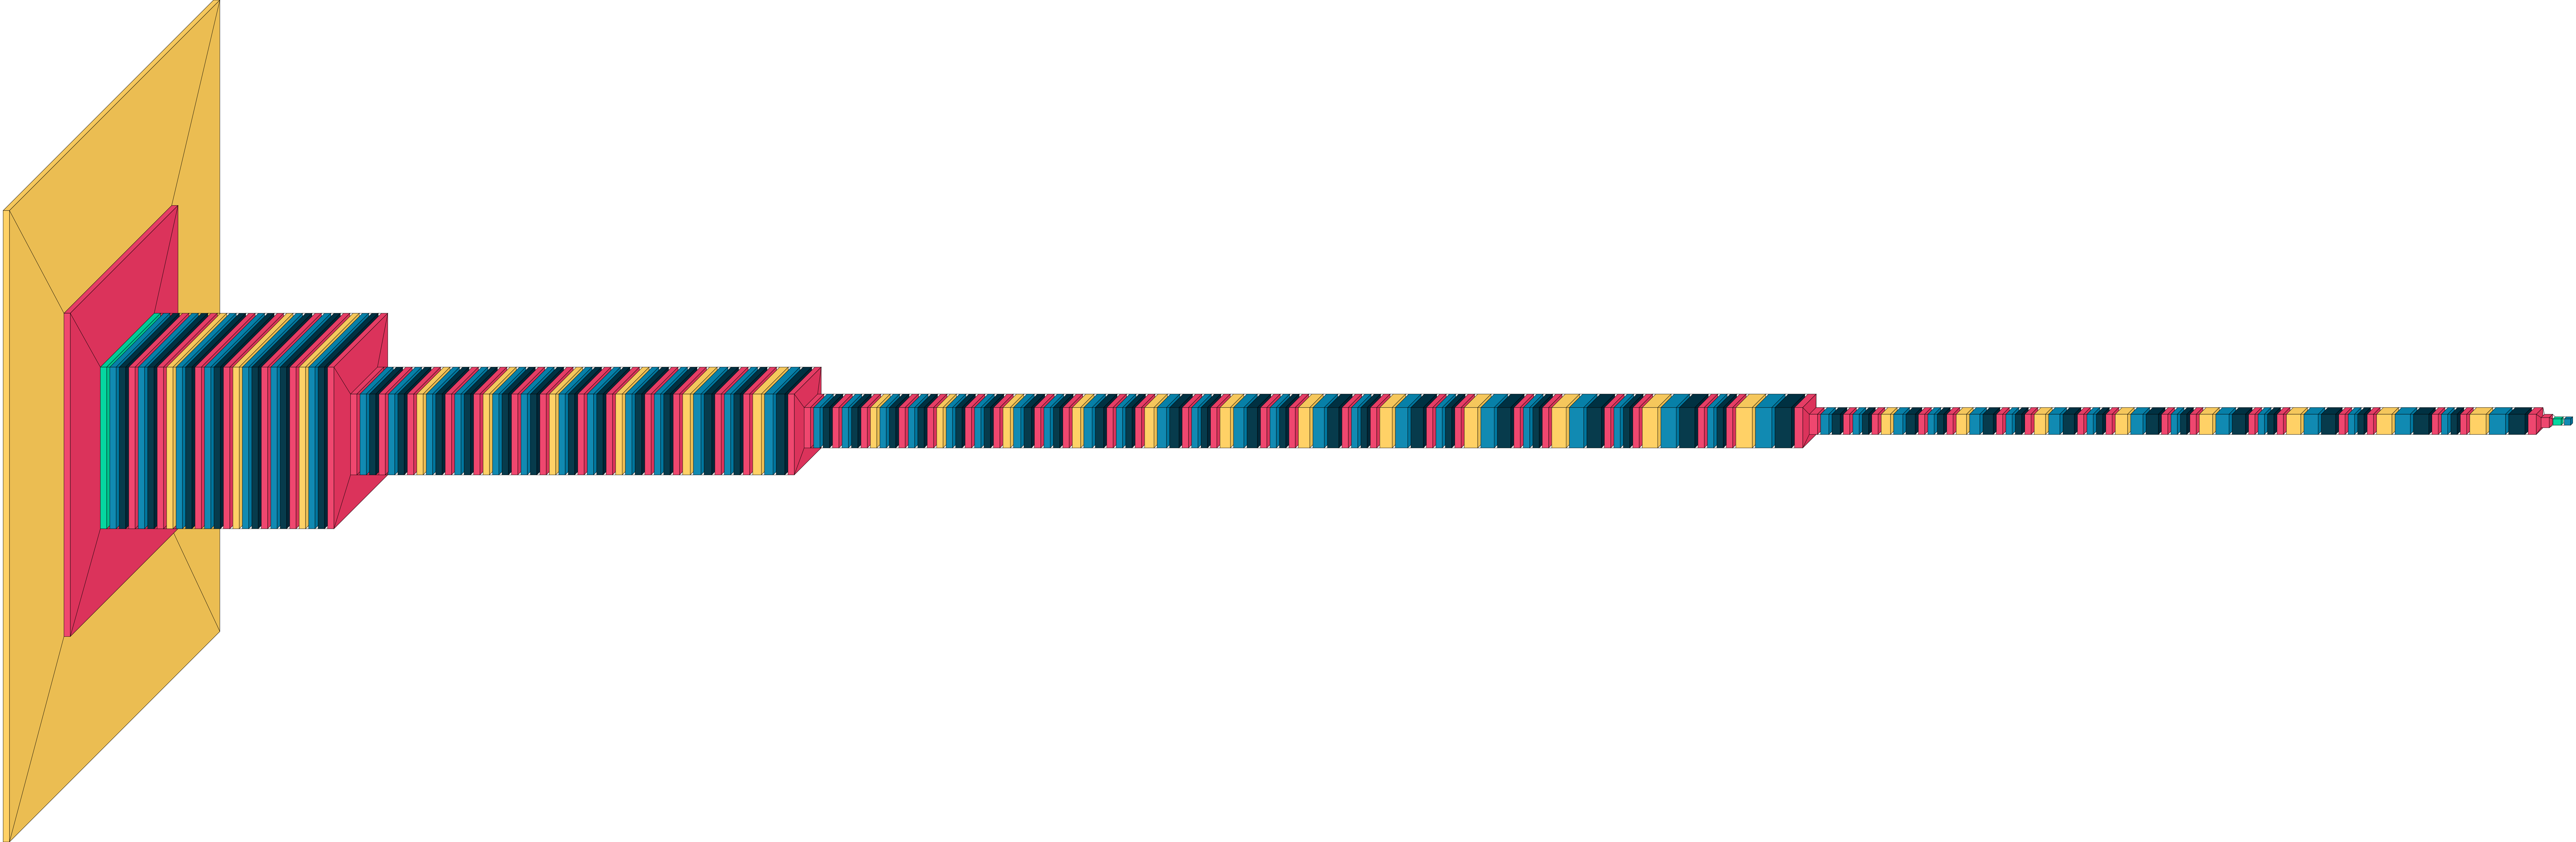

In [ ]:
import visualkeras
from tensorflow.keras.saving import load_model
densenet = load_model(TFR_PATH+"densenet/densenet_nocrop_best_model_val_loss.keras")
visualkeras.layered_view(densenet)

In [ ]:
from PIL import Image
img = visualkeras.layered_view(densenet)
img.save(TFR_PATH+"densenet/densenet_best_model_architecture.png", "PNG")